In [1]:
suppressMessages( library(dplyr) ) # Manipulações de funções
suppressMessages( library(mvtnorm) ) # Manipulações de funções
suppressMessages( library(tidyr) ) # Manipulações de funções

suppressMessages( library(arrow) ) # parquet
suppressMessages( library(snow) ) # parallel apply, sapply, lapply
suppressMessages( library(readxl) ) # read excel

source("MERT_functions.R")

# Regression trees
suppressMessages( library(rpart) )

# Pacotes para a construção de gráficos
suppressMessages( library(ggplot2) )
suppressMessages( library(cowplot) )
suppressMessages( library(latex2exp) )
suppressMessages( library(GGally) )

# Configurações padrão para os gráficos do ggplot2 no notebook
t = theme(plot.title = element_text(size=26, hjust=0.5),
          axis.title = element_text(size=20),
          axis.text = element_text(size=16),
          legend.title = element_text(size = 20),
          legend.text = element_text(size = 16),
          plot.subtitle = element_text(size = 18, face="bold"))
theme_set(theme_minimal()+t)

In [2]:
df <- read_parquet("Data/year_data.parquet")
df_rcl <- read_excel("Data/rcl_municipios_deflated.xlsx")
info_municipios <- read_excel("Data/info_municipios.xlsx")

df_rcl <- df_rcl %>% select(ds_municipio, ano_exercicio, RCL_defl)
info_municipios <- info_municipios %>% select(ds_municipio, atividade_principal, pib_nominal, populacao,
                                              quantidade_total_vagas, vereadores, area, alunos_escola)

head(df, 3)
head(df_rcl,3)
head(info_municipios,3)

ds_municipio,ds_orgao,cod_despesa,ano_exercicio,tp_orgao,vl_despesa,vl_despesa_defl
<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>
adamantina,camara municipal de adamantina,0101,2011,camara municipal,58989.28,112201.0
adamantina,camara municipal de adamantina,0301,2011,camara municipal,67840.79,129037.1
adamantina,camara municipal de adamantina,1101,2011,camara municipal,225347.46,428623.8


ds_municipio,ano_exercicio,RCL_defl
<chr>,<dbl>,<dbl>
adamantina,2010,143485107
adolfo,2010,24941031
aguai,2010,95722129


ds_municipio,atividade_principal,pib_nominal,populacao,quantidade_total_vagas,vereadores,area,alunos_escola
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
adamantina,demais servicos,1054541,35023,2002,9,411,2359
adolfo,"agricultura, inclusive apoio a agricultura e a pos colheita",99734,3571,458,9,211,478
aguai,demais servicos,942708,35954,1471,13,474,3489


In [3]:
# Standardize municipal wise numeric variables
info_municipios$pib_nominal <- (info_municipios$pib_nominal - mean(info_municipios$pib_nominal))/sd(info_municipios$pib_nominal)
info_municipios$populacao <- (info_municipios$populacao - mean(info_municipios$populacao))/sd(info_municipios$populacao)
info_municipios$quantidade_total_vagas <- (info_municipios$quantidade_total_vagas - mean(info_municipios$quantidade_total_vagas))/sd(info_municipios$quantidade_total_vagas)
info_municipios$vereadores <- (info_municipios$vereadores - mean(info_municipios$vereadores))/sd(info_municipios$vereadores)
info_municipios$area <- (info_municipios$area - mean(info_municipios$area))/sd(info_municipios$area)
info_municipios$alunos_escola <- (info_municipios$alunos_escola - mean(info_municipios$alunos_escola))/sd(info_municipios$alunos_escola)
head(info_municipios, 4)

ds_municipio,atividade_principal,pib_nominal,populacao,quantidade_total_vagas,vereadores,area,alunos_escola
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
adamantina,demais servicos,-0.17344558,-0.1394286,0.01443816,-0.5388542,0.08971652,-0.24601596
adolfo,"agricultura, inclusive apoio a agricultura e a pos colheita",-0.31728839,-0.4007474,-0.36750238,-0.5388542,-0.54114485,-0.45157834
aguai,demais servicos,-0.19029336,-0.1316934,-0.11691575,0.6950022,0.28843785,-0.12252554
agudos,industrias de transformacao,-0.02151688,-0.1228116,0.15568690,0.6950022,1.84035683,-0.05990606


In [4]:
# Standardize RCL variable
df_rcl_grouped <- df_rcl %>% group_by(ds_municipio) %>% summarise(
    ano_exercicio = list(ano_exercicio),
    RCL_defl = list(RCL_defl)
)
df_rcl_grouped$RCL_defl_std <- df_rcl_grouped$RCL_defl %>% sapply(function(x){
    meanx <- mean(x)
    sdx <- sd(x)
    (x - meanx) / sdx
})
df_rcl <- df_rcl_grouped %>% unnest(c(ano_exercicio, RCL_defl, RCL_defl_std))
head(df_rcl, 3)

ds_municipio,ano_exercicio,RCL_defl,RCL_defl_std
<chr>,<dbl>,<dbl>,<dbl>
adamantina,2010,143485107,-1.2770568
adamantina,2011,154390907,-0.9224490
adamantina,2012,152762472,-0.9753984


In [5]:
df <- merge(df, info_municipios, by = "ds_municipio")
df <- merge(df, df_rcl, by = c("ds_municipio", "ano_exercicio"))

head(df)

,ds_municipio,ano_exercicio,ds_orgao,cod_despesa,tp_orgao,vl_despesa,vl_despesa_defl,atividade_principal,pib_nominal,populacao,quantidade_total_vagas,vereadores,area,alunos_escola,RCL_defl,RCL_defl_std
,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,adamantina,2011,prefeitura municipal de adamantina,5242,prefeitura municipal,134690.75,256189.544,demais servicos,-0.1734456,-0.1394286,0.01443816,-0.5388542,0.08971652,-0.246016,154390907,-0.922449
2,adamantina,2011,camara municipal de adamantina,1145,camara municipal,6418.30,12207.975,demais servicos,-0.1734456,-0.1394286,0.01443816,-0.5388542,0.08971652,-0.246016,154390907,-0.922449
3,adamantina,2011,camara municipal de adamantina,5235,camara municipal,1430.00,2719.942,demais servicos,-0.1734456,-0.1394286,0.01443816,-0.5388542,0.08971652,-0.246016,154390907,-0.922449
4,adamantina,2011,prefeitura municipal de adamantina,3972,prefeitura municipal,497307.75,945907.910,demais servicos,-0.1734456,-0.1394286,0.01443816,-0.5388542,0.08971652,-0.246016,154390907,-0.922449
5,adamantina,2011,prefeitura municipal de adamantina,5248,prefeitura municipal,961810.00,1829417.875,demais servicos,-0.1734456,-0.1394286,0.01443816,-0.5388542,0.08971652,-0.246016,154390907,-0.922449
6,adamantina,2011,centro universitario de adamantina,3022,centro universitario,58926.66,112081.893,demais servicos,-0.1734456,-0.1394286,0.01443816,-0.5388542,0.08971652,-0.246016,154390907,-0.922449


## Modeling

For the modeling step, let's consider a subset of all the variables above. Also, we shall split the dataset into train and test components. For this to fit the predictive nature of this problem in time, the training set will be formed by observations up to 2017 and the test from 2018 up to 2021.

In [7]:
df_model <- df %>% select(ds_municipio, ds_orgao, cod_despesa, ano_exercicio, tp_orgao,
                          RCL_defl_std, pib_nominal, populacao, quantidade_total_vagas, vereadores, area,
                          vl_despesa_defl)
# Set all year to indexes 0 to 10
df_model$ano_exercicio <- df_model$ano_exercicio - 2011 

head(df_model, 4)

,ds_municipio,ds_orgao,cod_despesa,ano_exercicio,tp_orgao,RCL_defl_std,pib_nominal,populacao,quantidade_total_vagas,vereadores,area,vl_despesa_defl
,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,adamantina,prefeitura municipal de adamantina,5242,0,prefeitura municipal,-0.922449,-0.1734456,-0.1394286,0.01443816,-0.5388542,0.08971652,256189.544
2,adamantina,camara municipal de adamantina,1145,0,camara municipal,-0.922449,-0.1734456,-0.1394286,0.01443816,-0.5388542,0.08971652,12207.975
3,adamantina,camara municipal de adamantina,5235,0,camara municipal,-0.922449,-0.1734456,-0.1394286,0.01443816,-0.5388542,0.08971652,2719.942
4,adamantina,prefeitura municipal de adamantina,3972,0,prefeitura municipal,-0.922449,-0.1734456,-0.1394286,0.01443816,-0.5388542,0.08971652,945907.910


As it can be seen, the triple (ds_municipio, ds_orgao, cod_despesa) forms a new individual (associated to each triple there is a time series of expenses). Even though it would be possible to group all the triples into a single index variable, it seems more reasonable to consider at least one of them as covariates for the model, as they are nested covariates. The ideal approach to this would be something similar to the structure given by Galecki (2013) (page 248), in which there are N first-level groups (indexed by $i = 1, \dots, N$), each with $n_i$ second-level sub-groups (indexed by $j = 1, \dots, n_i$), which contain $n_{ij}$ observations each. A linear model for this example could be given by

\begin{equation*}
    Y_{ij} = X_{ij} \beta + Z_{1,ij} b_i + Z_{2,ij} b_{ij} + \varepsilon_{ij},
\end{equation*}

given that $b_i \sim N_{q_1}(0, D_1)$, $b_{ij} \sim N_{q_2}(0, D_2)$ and $\varepsilon \sim N_{n_{ij}}(0, R_{ij})$.

Note that in this case, since we have triples, it would be necessary another layer to this complex structure! For now this is not the most viable option. So in order to simplify this problem, let's at first consider that each individual is given by a triple but that the city is also a covariate for all of them. That way, even though essentially we suppose that different triples are independent from each other (clearly not the case), we insert a new covariate to account for part of the information loss associated with that hypothesis (at first I don't see a reason for it to be worse from the modelling perspective, as the information would not be lost wif we considered the variables in this way).


In [9]:
df_model <- df_model %>% group_by(ds_municipio, ds_orgao, cod_despesa) %>% mutate(id = cur_group_id()) %>% select(
    id, ds_municipio, ds_orgao, cod_despesa, ano_exercicio, tp_orgao, RCL_defl_std,
    pib_nominal, populacao, quantidade_total_vagas, vereadores, area, vl_despesa_defl
) %>% arrange(id) %>% as.data.frame()
head(df_model, 15)

,id,ds_municipio,ds_orgao,cod_despesa,ano_exercicio,tp_orgao,RCL_defl_std,pib_nominal,populacao,quantidade_total_vagas,vereadores,area,vl_despesa_defl
,<int>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,adamantina,camara municipal de adamantina,0101,0,camara municipal,-0.9224490,-0.1734456,-0.1394286,0.01443816,-0.5388542,0.08971652,112201.0
2,1,adamantina,camara municipal de adamantina,0101,1,camara municipal,-0.9753984,-0.1734456,-0.1394286,0.01443816,-0.5388542,0.08971652,124626.7
3,1,adamantina,camara municipal de adamantina,0101,2,camara municipal,-0.8141419,-0.1734456,-0.1394286,0.01443816,-0.5388542,0.08971652,124912.7
4,1,adamantina,camara municipal de adamantina,0101,3,camara municipal,-0.5187430,-0.1734456,-0.1394286,0.01443816,-0.5388542,0.08971652,128619.5
5,1,adamantina,camara municipal de adamantina,0101,4,camara municipal,-0.4638321,-0.1734456,-0.1394286,0.01443816,-0.5388542,0.08971652,126120.5
6,1,adamantina,camara municipal de adamantina,0101,5,camara municipal,-0.1305825,-0.1734456,-0.1394286,0.01443816,-0.5388542,0.08971652,128721.6
7,1,adamantina,camara municipal de adamantina,0101,6,camara municipal,0.6195416,-0.1734456,-0.1394286,0.01443816,-0.5388542,0.08971652,133236.7
8,1,adamantina,camara municipal de adamantina,0101,7,camara municipal,0.8447268,-0.1734456,-0.1394286,0.01443816,-0.5388542,0.08971652,134129.9
9,1,adamantina,camara municipal de adamantina,0101,8,camara municipal,1.3486765,-0.1734456,-0.1394286,0.01443816,-0.5388542,0.08971652,137279.1


In [10]:
id_correspondence <- df_model[!duplicated(df_model[,1:4]) , 1:4]
head(id_correspondence, 4)

,id,ds_municipio,ds_orgao,cod_despesa
,<int>,<chr>,<chr>,<chr>
1,1,adamantina,camara municipal de adamantina,0101
12,2,adamantina,camara municipal de adamantina,0301
23,3,adamantina,camara municipal de adamantina,1101
34,4,adamantina,camara municipal de adamantina,1133


In [12]:
df_model <- df_model %>% select(id, ds_municipio, cod_despesa, ano_exercicio, tp_orgao, RCL_defl_std, pib_nominal, populacao, quantidade_total_vagas, vereadores, area, vl_despesa_defl)
head(df_model, 4)

,id,ds_municipio,cod_despesa,ano_exercicio,tp_orgao,RCL_defl_std,pib_nominal,populacao,quantidade_total_vagas,vereadores,area,vl_despesa_defl
,<int>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,adamantina,0101,0,camara municipal,-0.9224490,-0.1734456,-0.1394286,0.01443816,-0.5388542,0.08971652,112201.0
2,1,adamantina,0101,1,camara municipal,-0.9753984,-0.1734456,-0.1394286,0.01443816,-0.5388542,0.08971652,124626.7
3,1,adamantina,0101,2,camara municipal,-0.8141419,-0.1734456,-0.1394286,0.01443816,-0.5388542,0.08971652,124912.7
4,1,adamantina,0101,3,camara municipal,-0.5187430,-0.1734456,-0.1394286,0.01443816,-0.5388542,0.08971652,128619.5


# Models 

In [13]:
df_grouped <- df_model %>% group_by(id) %>% summarise(
    ds_municipio = first(ds_municipio),
    cod_despesa = first(cod_despesa),
    ano_exercicio = list(ano_exercicio),
    vl_despesa_defl = list(vl_despesa_defl),
    RCL_defl_std = list(RCL_defl_std),
    pib_nominal = first(pib_nominal),
    populacao = first(populacao), 
    quantidade_total_vagas = first(quantidade_total_vagas),
    vereadores = first(vereadores),
    area = first(area),
    tp_orgao = first(tp_orgao),
    size = n()
)

df_grouped <- df_grouped[df_grouped$tp_orgao %in% c("camara municipal", "prefeitura municipal"), ]

# Get only the subjects that has more that 3 observations
df_grouped <- df_grouped %>% filter(size > 3)

head(df_grouped, 4)

id,ds_municipio,cod_despesa,ano_exercicio,vl_despesa_defl,RCL_defl_std,pib_nominal,populacao,quantidade_total_vagas,vereadores,area,tp_orgao,size
<int>,<chr>,<chr>,<list>,<list>,<list>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
1,adamantina,0101,"0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10","112201.0, 124626.7, 124912.7, 128619.5, 126120.5, 128721.6, 133236.7, 134129.9, 137279.1, 143778.2, 133434.3","-0.9224490, -0.9753984, -0.8141419, -0.5187430, -0.4638321, -0.1305825, 0.6195416, 0.8447268, 1.3486765, 0.4865935, 1.8026652",-0.1734456,-0.1394286,0.01443816,-0.5388542,0.08971652,camara municipal,11
2,adamantina,0301,"0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10","129037.1, 143327.3, 143656.4, 147919.4, 145045.5, 148036.9, 153229.5, 154256.7, 157878.5, 165352.8, 153456.8","-0.9224490, -0.9753984, -0.8141419, -0.5187430, -0.4638321, -0.1305825, 0.6195416, 0.8447268, 1.3486765, 0.4865935, 1.8026652",-0.1734456,-0.1394286,0.01443816,-0.5388542,0.08971652,camara municipal,11
3,adamantina,1101,"0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10","428623.8, 474318.9, 458145.5, 535496.0, 522345.9, 560648.2, 596970.4, 610514.4, 629768.8, 692775.1, 646460.0","-0.9224490, -0.9753984, -0.8141419, -0.5187430, -0.4638321, -0.1305825, 0.6195416, 0.8447268, 1.3486765, 0.4865935, 1.8026652",-0.1734456,-0.1394286,0.01443816,-0.5388542,0.08971652,camara municipal,11
4,adamantina,1133,"0, 1, 2, 3, 4","2484.087, 2682.756, 2761.091, 2770.878, 681.245","-0.9224490, -0.9753984, -0.8141419, -0.5187430, -0.4638321",-0.1734456,-0.1394286,0.01443816,-0.5388542,0.08971652,camara municipal,5


In [14]:
df_grouped %>% head

id,ds_municipio,cod_despesa,ano_exercicio,vl_despesa_defl,RCL_defl_std,pib_nominal,populacao,quantidade_total_vagas,vereadores,area,tp_orgao,size
<int>,<chr>,<chr>,<list>,<list>,<list>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
1,adamantina,0101,"0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10","112201.0, 124626.7, 124912.7, 128619.5, 126120.5, 128721.6, 133236.7, 134129.9, 137279.1, 143778.2, 133434.3","-0.9224490, -0.9753984, -0.8141419, -0.5187430, -0.4638321, -0.1305825, 0.6195416, 0.8447268, 1.3486765, 0.4865935, 1.8026652",-0.1734456,-0.1394286,0.01443816,-0.5388542,0.08971652,camara municipal,11
2,adamantina,0301,"0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10","129037.1, 143327.3, 143656.4, 147919.4, 145045.5, 148036.9, 153229.5, 154256.7, 157878.5, 165352.8, 153456.8","-0.9224490, -0.9753984, -0.8141419, -0.5187430, -0.4638321, -0.1305825, 0.6195416, 0.8447268, 1.3486765, 0.4865935, 1.8026652",-0.1734456,-0.1394286,0.01443816,-0.5388542,0.08971652,camara municipal,11
3,adamantina,1101,"0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10","428623.8, 474318.9, 458145.5, 535496.0, 522345.9, 560648.2, 596970.4, 610514.4, 629768.8, 692775.1, 646460.0","-0.9224490, -0.9753984, -0.8141419, -0.5187430, -0.4638321, -0.1305825, 0.6195416, 0.8447268, 1.3486765, 0.4865935, 1.8026652",-0.1734456,-0.1394286,0.01443816,-0.5388542,0.08971652,camara municipal,11
4,adamantina,1133,"0, 1, 2, 3, 4","2484.087, 2682.756, 2761.091, 2770.878, 681.245","-0.9224490, -0.9753984, -0.8141419, -0.5187430, -0.4638321",-0.1734456,-0.1394286,0.01443816,-0.5388542,0.08971652,camara municipal,5
5,adamantina,1137,"0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10","43548.99, 49447.68, 77973.42, 80711.29, 78380.24, 85656.21, 79665.17, 105609.00, 130886.64, 155721.72, 144572.21","-0.9224490, -0.9753984, -0.8141419, -0.5187430, -0.4638321, -0.1305825, 0.6195416, 0.8447268, 1.3486765, 0.4865935, 1.8026652",-0.1734456,-0.1394286,0.01443816,-0.5388542,0.08971652,camara municipal,11
6,adamantina,1142,"1, 2, 5, 10","2915.6642, 3004.7567, 2384.6645, 196.7391","-0.9753984, -0.8141419, -0.1305825, 1.8026652",-0.1734456,-0.1394286,0.01443816,-0.5388542,0.08971652,camara municipal,4


# 1. Only time as covariate + random intercept

In [10]:
set.seed(11218201)

# N <- 91862 # Takes too long (5 minutes per iteration)

# 4000 subjects used for training (of these 4000, observations after 2018 are also considered as test)
N_train <- 4000
# 1000 subjects used for test (never seen by the model before)
N_test <- 1000

sample_train <- sample(df_grouped$id, N_train)
sample_test <- sample(df_grouped$id[ !(df_grouped$id %in% sample_train) ], N_test)

df_grouped_train <- df_grouped %>% filter(id %in% sample_train) %>% arrange(id)

df_grouped_test <- df_grouped %>% filter(id %in% sample_test) %>% arrange(id)

# Remove the expense codes that are not accounted for on the training set!! This may be a future problem to be considered!!
cod_despesa_train <- unique(df_grouped_train$cod_despesa)
cod_despesa_test <- unique(df_grouped_test$cod_despesa)
df_grouped_test <- df_grouped_test %>% filter(!(cod_despesa %in% cod_despesa_test[ !cod_despesa_test %in% cod_despesa_train ]))

In [9]:
set.seed(11218201)

# N <- 91862 # Takes too long (5 minutes per iteration)

# 4000 subjects used for training (of these 4000, observations after 2018 are also considered as test)
N_train <- 4000
# 1000 subjects used for test (never seen by the model before)
N_test <- 1000

sample_train <- sample(df_grouped$id, N_train)
sample_test <- sample(df_grouped$id[ !(df_grouped$id %in% sample_train) ], N_test)

df_grouped_train <- df_grouped %>% filter(id %in% sample_train) %>% arrange(id)

df_grouped_test <- df_grouped %>% filter(id %in% sample_test) %>% arrange(id)

# Remove the expense codes that are not accounted for on the training set!! This may be a future problem to be considered!!
cod_despesa_train <- unique(df_grouped_train$cod_despesa)
cod_despesa_test <- unique(df_grouped_test$cod_despesa)
df_grouped_test <- df_grouped_test %>% filter(!(cod_despesa %in% cod_despesa_test[ !cod_despesa_test %in% cod_despesa_train ]))

df_model_train <- df_grouped_train %>% unnest(c(ano_exercicio, vl_despesa_defl, RCL_defl)) %>% arrange(id)
df_model_test <- df_grouped_test %>% unnest(c(ano_exercicio, vl_despesa_defl, RCL_defl)) %>% arrange(id)

# Pass the new observations (from 2019 to 2021) from the test set and remove them from the training set
df_model_test <- rbind(
    df_model_train %>% filter(ano_exercicio >= 8),
    df_model_test
) %>% as.data.frame
df_model_train <- df_model_train %>% filter(ano_exercicio < 8)

# Regroup the data.frames for train and test
df_grouped_train <- df_model_train %>% group_by(id) %>% summarise(
    ds_municipio = first(ds_municipio),
    cod_despesa = first(cod_despesa),
    ano_exercicio = list(ano_exercicio),
    vl_despesa_defl = list(vl_despesa_defl),
    RCL_defl = list(RCL_defl),
    pib_nominal = first(pib_nominal),
    populacao = first(populacao), 
    quantidade_total_vagas = first(quantidade_total_vagas),
    vereadores = first(vereadores),
    area = first(area),
    tp_orgao = first(tp_orgao)
)
df_grouped_test <- df_model_test %>% group_by(id) %>% summarise(
    ds_municipio = first(ds_municipio),
    cod_despesa = first(cod_despesa),
    ano_exercicio = list(ano_exercicio),
    vl_despesa_defl = list(vl_despesa_defl),
    RCL_defl = list(RCL_defl),
    pib_nominal = first(pib_nominal),
    populacao = first(populacao), 
    quantidade_total_vagas = first(quantidade_total_vagas),
    vereadores = first(vereadores),
    area = first(area),
    tp_orgao = first(tp_orgao)
)

head(df_grouped_train, 4)
head(df_grouped_test, 4)

id,ds_municipio,cod_despesa,ano_exercicio,vl_despesa_defl,RCL_defl,pib_nominal,populacao,quantidade_total_vagas,vereadores,area,tp_orgao
<int>,<chr>,<chr>,<list>,<list>,<list>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
6,adamantina,1142,"1, 2, 5","2915.664, 3004.757, 2384.664","152762472, 157721842, 178744402",1054541,35023,2002,9,411,camara municipal
7,adamantina,1143,"0, 1, 2, 3, 4, 5, 6, 7","40206.74, 43915.32, 46220.50, 52578.12, 50971.23, 54240.42, 57195.64, 61016.78","154390907, 152762472, 157721842, 166806702, 168495462, 178744402, 201814127, 208739597",1054541,35023,2002,9,411,camara municipal
238,adamantina,1199,"0, 1, 2, 3, 4, 5, 6, 7","6520467, 6781043, 8094918, 8743904, 7627676, 8148232, 8487590, 9244921","154390907, 152762472, 157721842, 166806702, 168495462, 178744402, 201814127, 208739597",1054541,35023,2002,9,411,prefeitura municipal
239,adamantina,1300,"0, 1, 2, 3, 4, 5, 6, 7","9541898, 10794647, 11627504, 12567725, 11239167, 11439769, 12232145, 12834843","154390907, 152762472, 157721842, 166806702, 168495462, 178744402, 201814127, 208739597",1054541,35023,2002,9,411,prefeitura municipal


id,ds_municipio,cod_despesa,ano_exercicio,vl_despesa_defl,RCL_defl,pib_nominal,populacao,quantidade_total_vagas,vereadores,area,tp_orgao
<int>,<chr>,<chr>,<list>,<list>,<list>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
6,adamantina,1142,10,196.7391,238200556,1054541,35023,2002,9,411,camara municipal
7,adamantina,1143,"8, 9, 10","68024.48, 72551.48, 65919.36","224238341, 197725370, 238200556",1054541,35023,2002,9,411,camara municipal
225,adamantina,0101,"0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10","5702634, 5916981, 5729612, 5848270, 4075986, 4136073, 3987674, 3866611, 3734217, 3449763, 2966992","154390907, 152762472, 157721842, 166806702, 168495462, 178744402, 201814127, 208739597, 224238341, 197725370, 238200556",1054541,35023,2002,9,411,prefeitura municipal
238,adamantina,1199,"8, 9, 10","11047852, 2997321, 2584279","224238341, 197725370, 238200556",1054541,35023,2002,9,411,prefeitura municipal


In [10]:
njobs <- parallel::detectCores()

cl <- makeCluster(getOption("cl.cores", njobs))
clusterExport(cl, c("df_grouped", "unnest"), envir = environment())

start <- Sys.time()

# The response variable by subject
Ys_train <- df_grouped_train$vl_despesa_defl
Ys_test <- df_grouped_test$vl_despesa_defl

# Recover all the matrices Xi from every subject (only time and response variable)
Xis_train1 <- parApply(cl, df_grouped_train, 1, function(row){
    dfi <- unnest(as.data.frame(row), cols = c("vl_despesa_defl", "ano_exercicio"))
    Xi <- model.matrix(vl_despesa_defl ~ ano_exercicio, data = dfi)
    list(Xi)
}) %>% unlist(recursive = FALSE)
Xis_test1 <- parApply(cl, df_grouped_test, 1, function(row){
    dfi <- unnest(as.data.frame(row), cols = c("vl_despesa_defl", "ano_exercicio"))
    Xi <- model.matrix(vl_despesa_defl ~ ano_exercicio, data = dfi)
    list(Xi)
}) %>% unlist(recursive = FALSE)


# Recover all the matrices Zi from every subject according to the desired model (random intercept in this case)
Zis_train1 <- parApply(cl, df_grouped_train, 1, function(row){
    dfi <- unnest(as.data.frame(row), cols = c("vl_despesa_defl", "ano_exercicio"))
    Zi <- model.matrix(vl_despesa_defl ~ 1, data = dfi)
    list(Zi)
}) %>% unlist(recursive = FALSE)
Zis_test1 <- parApply(cl, df_grouped_test, 1, function(row){
    dfi <- unnest(as.data.frame(row), cols = c("vl_despesa_defl", "ano_exercicio"))
    Zi <- model.matrix(vl_despesa_defl ~ 1, data = dfi)
    list(Zi)
}) %>% unlist(recursive = FALSE)

Sys.time() - start

# Encerra a atividade do cluster (evita vazamento de memória)
stopCluster(cl)

Time difference of 15.87373 secs

In [11]:
start <- Sys.time()
    fit_MERT1 <- train_MERT(df_model_train, Y ~ ano_exercicio, Ys_train, Xis_train1, Zis_train1, 1.0e-6, "vl_despesa_defl", max_iter = 5000)
Sys.time() - start

Converged after 350 iterations. Difference in GLLs of 1.008622e-06

Time difference of 4.980092 mins

In [12]:
head(unlist(fit_MERT1$bi))
tail(unlist(fit_MERT1$bi))

6          7        238        239        272        318 
-1012544.7  -990746.5  6795097.7 10319639.8  -707414.9  -909160.8

178628     178725     178774     178785     178797     178809 
-1034623.4 -1016180.4  -992768.4  -975025.3  -882239.3  -985059.2

In [13]:
fit_MERT1$D

4.674302e+13


id,ds_municipio,cod_despesa,ano_exercicio,vl_despesa_defl,RCL_defl,pib_nominal,populacao,quantidade_total_vagas,vereadores,area,tp_orgao,size,pred1
<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>
6,adamantina,1142,1,2915.664,152762472,1054541,35023,2002,9,411,camara municipal,4,44195.71
6,adamantina,1142,2,3004.757,157721842,1054541,35023,2002,9,411,camara municipal,4,44195.71
6,adamantina,1142,5,2384.664,178744402,1054541,35023,2002,9,411,camara municipal,4,44195.71
7,adamantina,1143,0,40206.736,154390907,1054541,35023,2002,9,411,camara municipal,11,65993.91


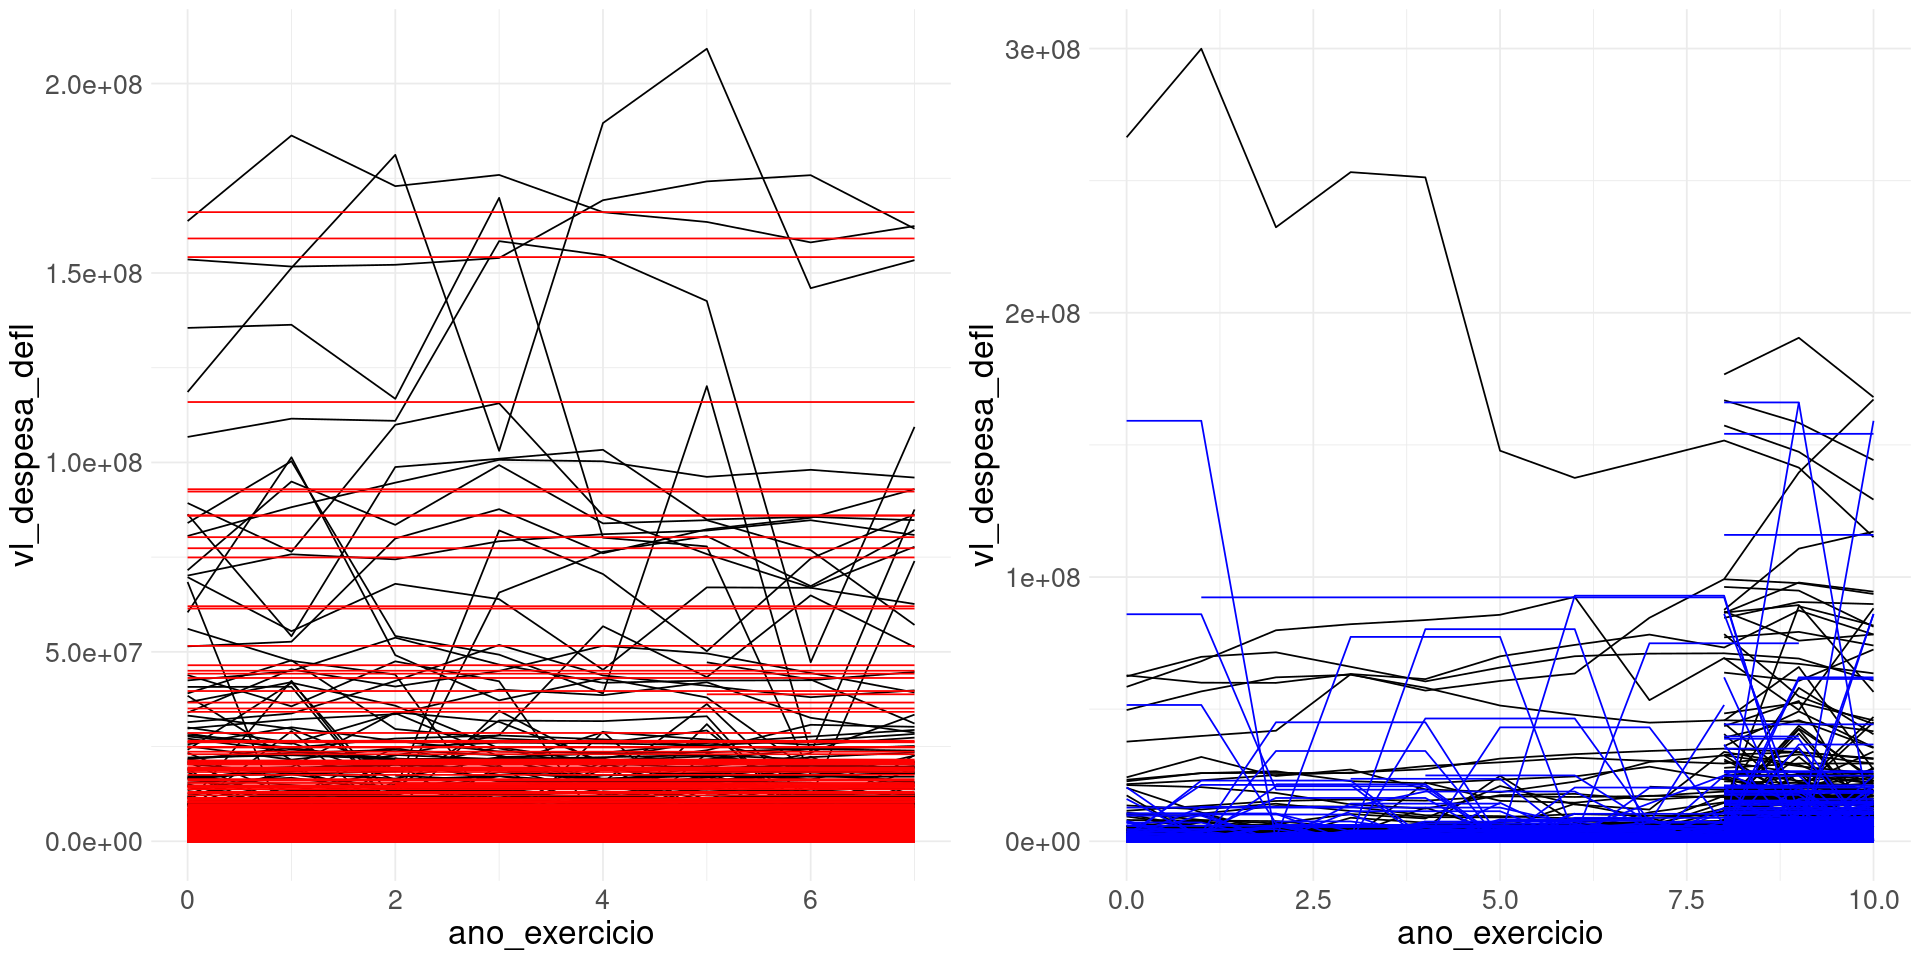

In [14]:
y_pred_grouped_train1 <- predict_MERT(fit_MERT1, Xis_train1, Zis_train1, df_grouped_train$id)
y_pred_grouped_test1 <- predict_MERT(fit_MERT1, Xis_test1, Zis_test1, df_grouped_test$id)

y_pred_train1 <- unlist(y_pred_grouped_train1)
y_pred_test1 <- unlist(y_pred_grouped_test1)

df_model_train$pred1 <- y_pred_train1
df_model_test$pred1 <- y_pred_test1
head(df_model_train, 4)

g1 <- ggplot(df_model_train)+
    geom_line(aes(x = ano_exercicio, y = vl_despesa_defl, group = id))+
    geom_line(aes(x = ano_exercicio, y = pred1, group = id), color = "red")
g2 <- ggplot(df_model_test)+
    geom_line(aes(x = ano_exercicio, y = vl_despesa_defl, group = id))+
    geom_line(aes(x = ano_exercicio, y = pred1, group = id), color = "blue")

options(repr.plot.width = 16, repr.plot.height = 8)
plot_grid(g1, g2)

As we can observe, the fixed effects component seems not to be able to capture any time tendency, while the random intercepts seem to converge to the mean of each expense time series. This result seems to be equivalent to a mean model, in which for each subject we simply choose the mean along time as the predicted value.

# 2. Only time as covariate + random intercept and slope

In [15]:
Xis_train2 <- Xis_train1
Xis_test2 <- Xis_test1

cl <- makeCluster(getOption("cl.cores", njobs))
clusterExport(cl, c("df_grouped", "unnest"), envir = environment())

# Recover all the matrices Zi from every subject according to the desired model (random intercept in this case)
Zis_train2 <- parApply(cl, df_grouped_train, 1, function(row){
    dfi <- unnest(as.data.frame(row), cols = c("vl_despesa_defl", "ano_exercicio"))
    Zi <- model.matrix(vl_despesa_defl ~ 1 + ano_exercicio, data = dfi)
    list(Zi)
}) %>% unlist(recursive = FALSE)
Zis_test2 <- parApply(cl, df_grouped_test, 1, function(row){
    dfi <- unnest(as.data.frame(row), cols = c("vl_despesa_defl", "ano_exercicio"))
    Zi <- model.matrix(vl_despesa_defl ~ 1 + ano_exercicio, data = dfi)
    list(Zi)
}) %>% unlist(recursive = FALSE)

stopCluster(cl)

In [16]:
start <- Sys.time()
    fit_MERT2 <- train_MERT(df_model_train, Y ~ ano_exercicio, Ys_train, Xis_train2, Zis_train2, 1.0e-6, "vl_despesa_defl", max_iter = 5000)
Sys.time() - start

Converged after 582 iterations. Difference in GLLs of 1.007458e-06

Time difference of 8.881826 mins

In [17]:
head(fit_MERT2$bi, 3)
tail(fit_MERT2$bi, 3)

-1030386.174
5886.605
-994752.167
3170.242
5998740.9
240886.9


-1017039.87
11392.28
-820175.07
-16766.55
-979066.1259
327.4861


In [18]:
fit_MERT2$D
Cor <- fit_MERT2$D
Cor[1,2] <- Cor[2,1] <- Cor[1,2] / (sqrt(Cor[1,1] * Cor[2,2]))
Cor[1,1] <- Cor[2,2] <- 1
Cor

5.234605e+13,-1.330795e+12
-1.330795e+12,3.186150e+11


1.0000000,-0.3258637
-0.3258637,1.0000000


id,ds_municipio,cod_despesa,ano_exercicio,vl_despesa_defl,RCL_defl,pib_nominal,populacao,quantidade_total_vagas,vereadores,area,tp_orgao,size,pred1,pred2
<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>
6,adamantina,1142,1,2915.664,152762472,1054541,35023,2002,9,411,camara municipal,4,44195.71,19757.04
6,adamantina,1142,2,3004.757,157721842,1054541,35023,2002,9,411,camara municipal,4,44195.71,25643.64
6,adamantina,1142,5,2384.664,178744402,1054541,35023,2002,9,411,camara municipal,4,44195.71,43303.46
7,adamantina,1143,0,40206.736,154390907,1054541,35023,2002,9,411,camara municipal,11,65993.91,49504.44


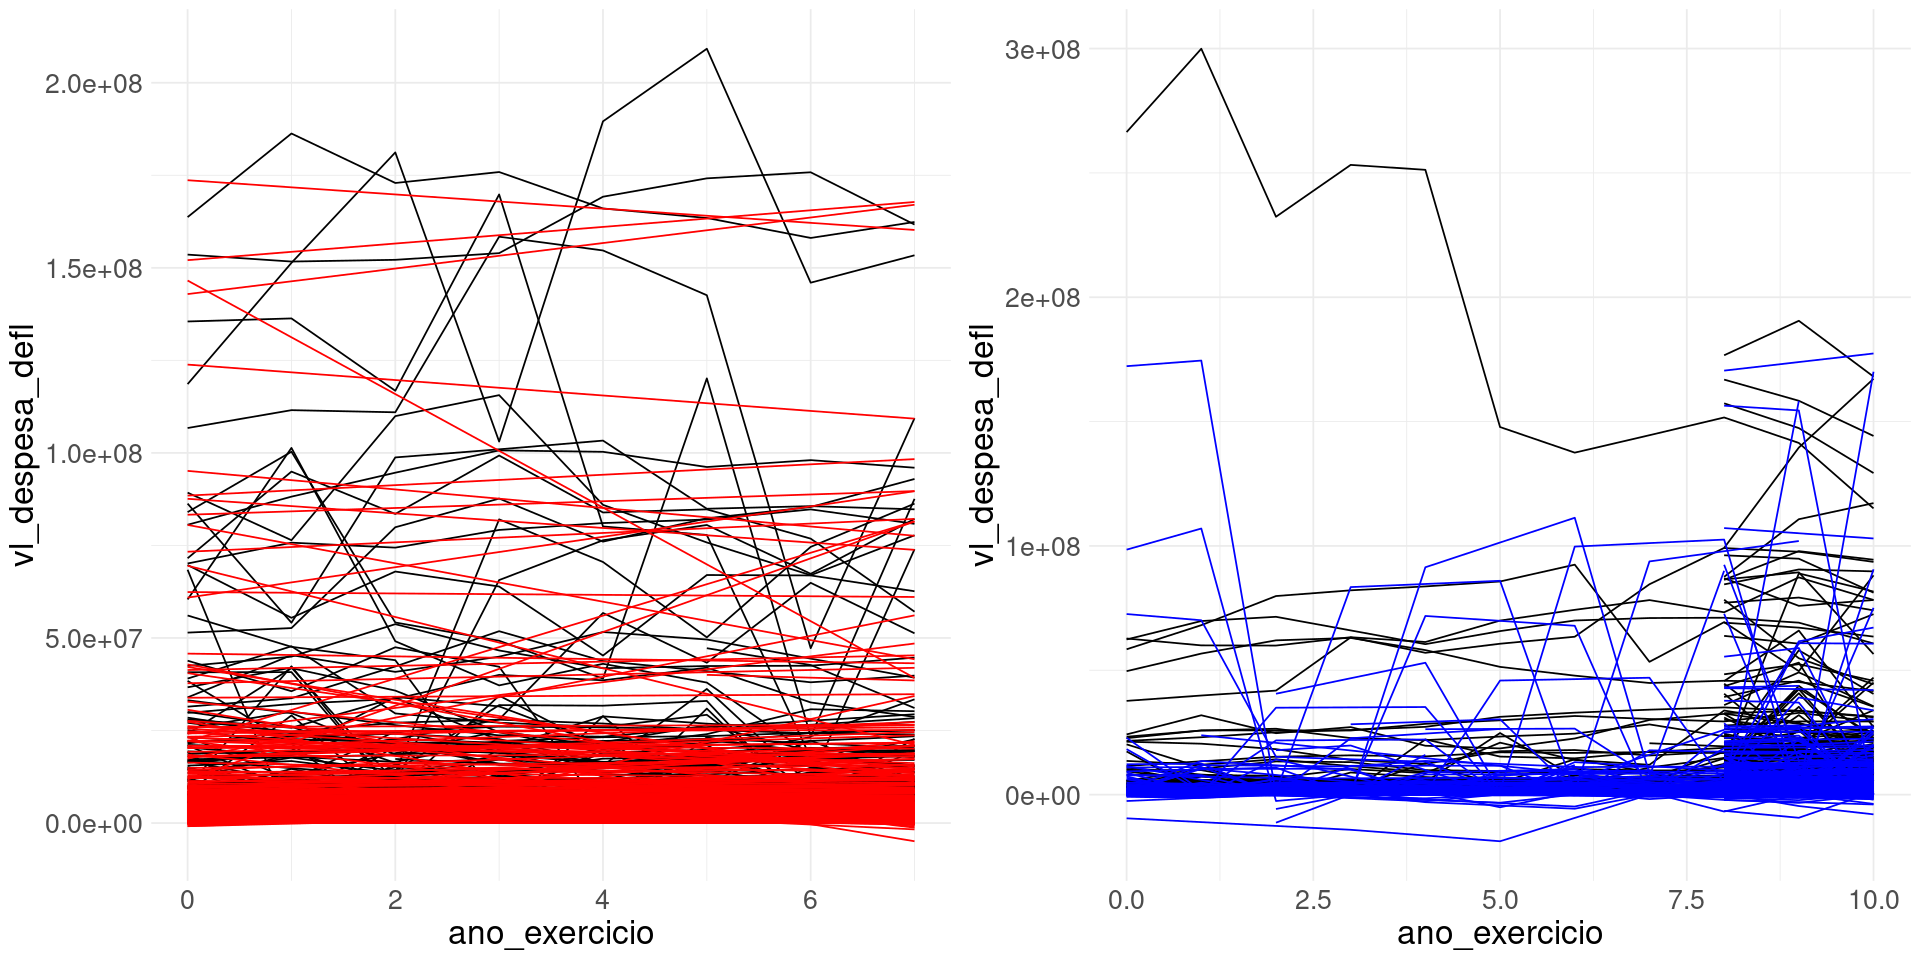

In [19]:
y_pred_grouped_train2 <- predict_MERT(fit_MERT2, Xis_train2, Zis_train2, df_grouped_train$id)
y_pred_grouped_test2 <- predict_MERT(fit_MERT2, Xis_test2, Zis_test2, df_grouped_test$id)

y_pred_train2 <- unlist(y_pred_grouped_train2)
y_pred_test2 <- unlist(y_pred_grouped_test2)

df_model_train$pred2 <- y_pred_train2
df_model_test$pred2 <- y_pred_test2
head(df_model_train, 4)

g1 <- ggplot(df_model_train)+
    geom_line(aes(x = ano_exercicio, y = vl_despesa_defl, group = id))+
    geom_line(aes(x = ano_exercicio, y = pred2, group = id), color = "red")
g2 <- ggplot(df_model_test)+
    geom_line(aes(x = ano_exercicio, y = vl_despesa_defl, group = id))+
    geom_line(aes(x = ano_exercicio, y = pred2, group = id), color = "blue")

options(repr.plot.width = 16, repr.plot.height = 8)
plot_grid(g1, g2)

# 3. All the covariates + random intercept and slope

In [20]:
X_train3 <- model.matrix(vl_despesa_defl ~ id + ano_exercicio + RCL_defl + pib_nominal + populacao + quantidade_total_vagas + vereadores + area, data = df_model_train) %>% as.data.frame
X_test3 <- model.matrix(vl_despesa_defl ~ id + ano_exercicio + RCL_defl + pib_nominal + populacao + quantidade_total_vagas + vereadores + area, data = df_model_test) %>% as.data.frame

X_train3 <- cbind(X_train3, df_model_train$tp_orgao, df_model_train$ds_municipio, df_model_train$cod_despesa)
colnames(X_train3)[(ncol(X_train3) - 2):ncol(X_train3)] <- c("tp_orgao", "ds_municipio", "cod_despesa")
X_test3 <- cbind(X_test3, df_model_test$tp_orgao, df_model_test$ds_municipio, df_model_test$cod_despesa)
colnames(X_test3)[(ncol(X_test3) - 2):ncol(X_test3)] <- c("tp_orgao", "ds_municipio", "cod_despesa")

# Use the id to split the tables and discard it
Xis_train3 <- X_train3 %>% split(f = X_train3$id)
Xis_train3 <- lapply(Xis_train3, function(x){
    x[,colnames(x) != "id"]
})

# Use the id to split the tables and discard it
Xis_test3 <- X_test3 %>% split(f = X_test3$id)
Xis_test3 <- lapply(Xis_test3, function(x){
    x[,colnames(x) != "id"]
})

Zis_train3 <- Zis_train2
Zis_test3 <- Zis_test2

# Z_train3 <- X_train3 %>% select("(Intercept)", id, ano_exercicio)
# # Use the id to split the tables and discard it
# Zis_train3 <- Z_train3 %>% split(f = Z_train3$id)
# Zis_train3 <- lapply(Zis_train3, function(x){
#     x[,colnames(x) != "id"]
# })


# Z_test3 <- X_test3 %>% select("(Intercept)", id, ano_exercicio)

# # Use the id to split the tables and discard it
# Zis_test3 <- Z_test3 %>% split(f = Z_test3$id)
# Zis_test3 <- lapply(Zis_test3, function(x){
#     x[,colnames(x) != "id"]
# })

In [21]:
start <- Sys.time()
    fit_MERT3 <- train_MERT(df_model_train,
                            Y ~ ano_exercicio + RCL_defl + pib_nominal + populacao + quantidade_total_vagas + vereadores + area + tp_orgao + ds_municipio + cod_despesa,
                            Ys_train, Xis_train3, Zis_train3, 1.0e-6, "vl_despesa_defl", max_iter = 5000)
Sys.time() - start

Converged after 239 iterations. Difference in GLLs of 1.03144e-06

Time difference of 4.001782 mins

In [22]:
Cor <- fit_MERT3$D
Cor[1,2] <- Cor[2,1] <- Cor[1,2] / (sqrt(Cor[1,1] * Cor[2,2]))
Cor[1,1] <- Cor[2,2] <- 1
Cor

1.0000000,-0.5430951
-0.5430951,1.0000000


In [23]:
y_pred_grouped_test3 <- predict_MERT(fit_MERT3, Xis_test3, Zis_test3, df_grouped_test$id)
y_pred_test3 <- unlist(y_pred_grouped_test3)

id,ds_municipio,cod_despesa,ano_exercicio,vl_despesa_defl,RCL_defl,pib_nominal,populacao,quantidade_total_vagas,vereadores,area,tp_orgao,size,pred1,pred2,pred3
<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>
6,adamantina,1142,1,2915.664,152762472,1054541,35023,2002,9,411,camara municipal,4,44195.71,19757.04,40778.47
6,adamantina,1142,2,3004.757,157721842,1054541,35023,2002,9,411,camara municipal,4,44195.71,25643.64,44256.36
6,adamantina,1142,5,2384.664,178744402,1054541,35023,2002,9,411,camara municipal,4,44195.71,43303.46,54690.04
7,adamantina,1143,0,40206.736,154390907,1054541,35023,2002,9,411,camara municipal,11,65993.91,49504.44,133392.05


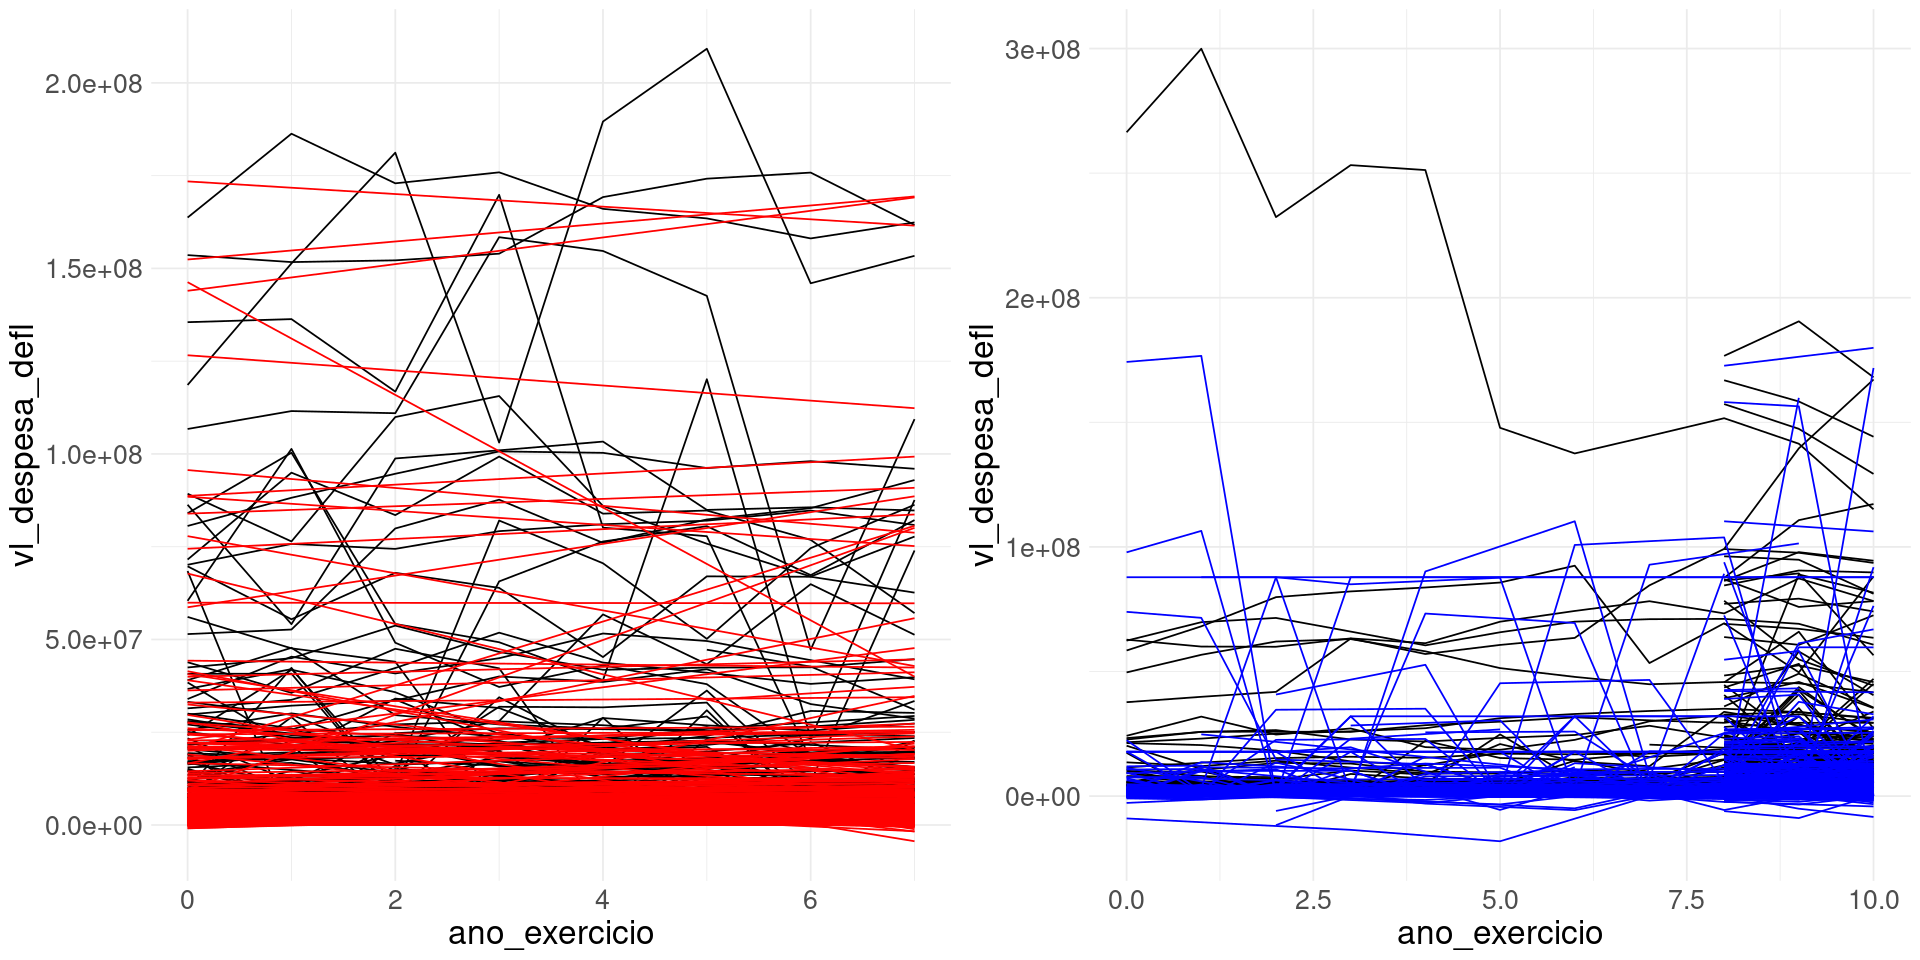

In [24]:
y_pred_grouped_train3 <- predict_MERT(fit_MERT3, Xis_train3, Zis_train3, df_grouped_train$id)
y_pred_grouped_test3 <- predict_MERT(fit_MERT3, Xis_test3, Zis_test3, df_grouped_test$id)

y_pred_train3 <- unlist(y_pred_grouped_train3)
y_pred_test3 <- unlist(y_pred_grouped_test3)

df_model_train$pred3 <- y_pred_train3
df_model_test$pred3 <- y_pred_test3
head(df_model_train, 4)

g1 <- ggplot(df_model_train)+
    geom_line(aes(x = ano_exercicio, y = vl_despesa_defl, group = id))+
    geom_line(aes(x = ano_exercicio, y = pred3, group = id), color = "red")
g2 <- ggplot(df_model_test)+
    geom_line(aes(x = ano_exercicio, y = vl_despesa_defl, group = id))+
    geom_line(aes(x = ano_exercicio, y = pred3, group = id), color = "blue")

options(repr.plot.width = 16, repr.plot.height = 8)
plot_grid(g1, g2)